#Exploritory Data Analysis for Central Car Auction

**Data Source**
Webpage:  http://www.centralcarauctions.com/trade/vehicles/price-guide/price-guide?page=1

Date Accessed: April 2015 

Steps in this notebook: 

1. Explore distibution of target output variable and each feature separately. 
2. Explore the joint distribution of the traget variable with each feature. 

In [1]:
import os
import pickle

import pandas as pd
import seaborn as sns
from scipy import stats

import source_data 
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Configure plotting parameters and colors
sns.set(style="darkgrid")
sns.set_context('talk')
muted = sns.color_palette("muted")
#sns.palplot(sns.color_palette("muted"))

## Fetch, Parse, Preprocess and Encode Data

In [3]:
# Fetch new data if it has not been downloaded already. Else read from disk
if not os.path.exists('cca_data_enc.csv'): 
    html_entries = source_data.fetch_all_html_entries()
    df_raw = source_data.parse_html_entries(html_entries, output_file='cca_data_raw.csv')
    df_pro = source_data.preprocess(df_raw, output_file='cca_data_pro.csv')
    df_enc, decoder = source_data.encode(df_pro, output_file='cca_data_enc.csv')
else:
    df_raw, df_pro, df_enc, decoder = source_data.load_data_from_disk()

### Unique Value Counts per Feature 

In [4]:
for heading in ['make', 'model', 'trim', 'class', 'year', 'MOT',]:
    print ('%s : %s' % (heading, len(df_enc[heading].value_counts())))
print('\nTotal Observations: ', len(df_enc))

make : 46
model : 393
trim : 2166
class : 28
year : 195
MOT : 16

Total Observations:  4136


## Price Distribution

The distribution is heavily squewed to the right, and modeled well with an exponential distribution. 

Therefore a lot of cars in this data set are sold for a low price. 

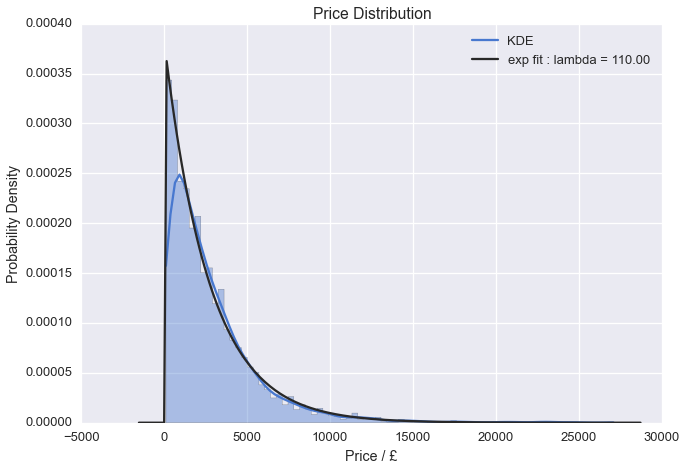

In [5]:
# Distribution fitting
param = stats.expon.fit(df_enc['price']) 

sns.distplot(df_enc['price'], fit=stats.expon, color=muted[0], 
             kde_kws={"label": "KDE"},
             hist_kws={"histtype": "stepfilled"}, 
             fit_kws={"label": "exp fit : lambda = {0:.2f}".format(param[0])}
            )
plt.legend()
plt.title('Price Distribution')
plt.xlabel(u'Price / £')
plt.ylabel('Probability Density')
sns.despine()

## Milage Distribution

The distribution looks close to normal, but is modeled better by a gamma distribution due to values have a lower bound of being > 0. 

Total number of missing mileage observations: 0


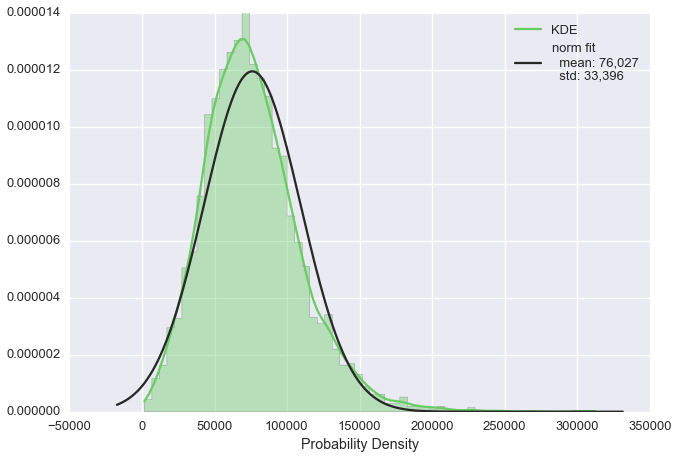

In [6]:
# Remove encoded NAs 
nas = sum(df_enc['mileage'] > 999999999)
print('Total number of missing mileage observations: {}'.format(nas))
data = df_enc.loc[df_enc['mileage'] < 999999999, :]

# Distribution fitting - Normal Distribution
param = stats.norm.fit(data['mileage']) 

sns.distplot(data['mileage'], fit=stats.norm, color=muted[1],
             kde_kws={"label": "KDE"},
             hist_kws={"histtype": "stepfilled"}, 
             fit_kws={"label": "norm fit\n  mean: {0:,.0f}\n  std: {1:,.0f}".format(param[0], param[1])}
            )
plt.legend()
plt.xlabel(u'Mileage')
plt.xlabel(u'Probability Density')
sns.despine()

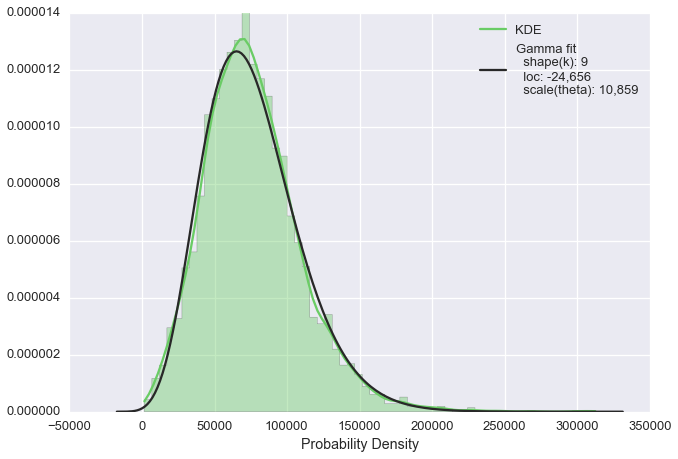

In [7]:
# Distribution fitting - Gamma Distribution
param = stats.gamma.fit(data['mileage']) 

fit_label = ("Gamma fit\n  shape(k): {0:,.0f}\n  loc: {1:,.0f}\n  scale(theta): "
             "{2:,.0f}".format(param[0], param[1], param[2]))

sns.distplot(data['mileage'], fit=stats.gamma, color=muted[1],
             kde_kws={"label": "KDE"},
             hist_kws={"histtype": "stepfilled"}, 
             fit_kws={"label": fit_label}
            )
plt.legend()
plt.xlabel(u'Mileage')
plt.xlabel(u'Probability Density')
sns.despine()

In [8]:
print('Expected Value  = {:,.1f}'.format(param[0]*param[2]))
print('Variance = {:,.1f}'.format(param[0]*param[2]**2))
print('Std = {:,.1f}'.format(np.sqrt(param[0]*param[2]**2)))

Expected Value  = 100,682.5
Variance = 1,093,314,061.0
Std = 33,065.3


## Date of Manufacture Frequencies

Periodic spikes are seen at the times when new plates are released in March and September of each year. 

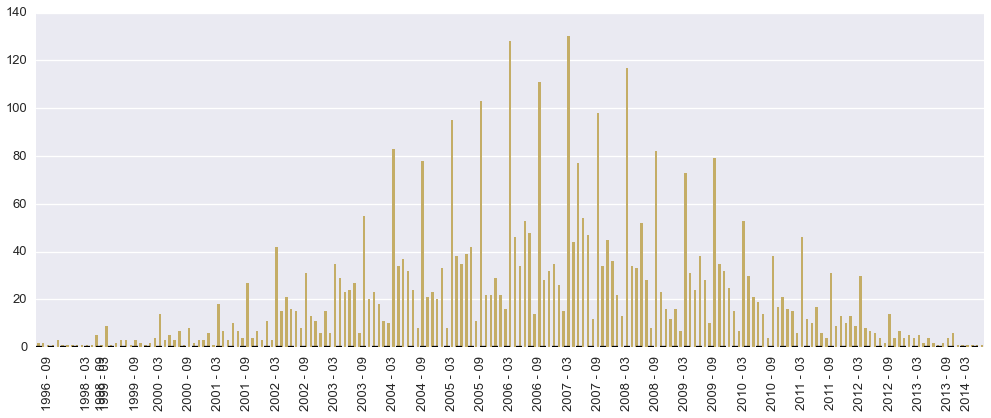

In [13]:
# Custom bar plot
plt.figure(figsize=(17,6))
year_counts = df_enc['year'].value_counts()
data = year_counts.sort_index()
data.plot(kind='bar', color=muted[4], linewidth=0.0)
plt.grid(axis='x')
# Fix for x labels
labels = data.index.tolist()
xlabs = [ts.strftime('%Y - %m') if ts.strftime('%m') in ('03', '09') else "" for ts in labels ]
ax = plt.gca()
ax.set_xticklabels(xlabs);

## Model Frequencies

The top 25 models of car are shown below. 

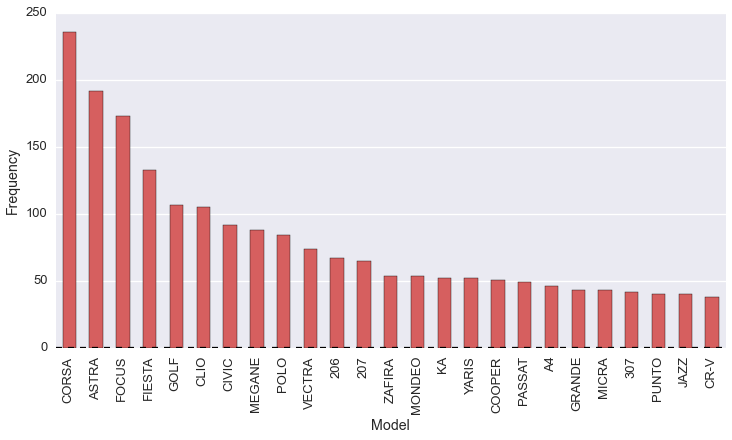

In [14]:
plt.figure(figsize=(12, 6))
model_counts = df_enc['model'].value_counts()
model_counts.index = decoder['model'][model_counts.index]
model_counts[:25].plot(kind='bar', color=muted[2])
plt.grid(axis='x')
sns.axlabel('Model', 'Frequency')

## Class Frequencies

Together the number of 3 door and 5 door hatchbacks make up 61% of the cars sold during this period. 

4136  Observations in Total
 63.03% are Hatchbacks


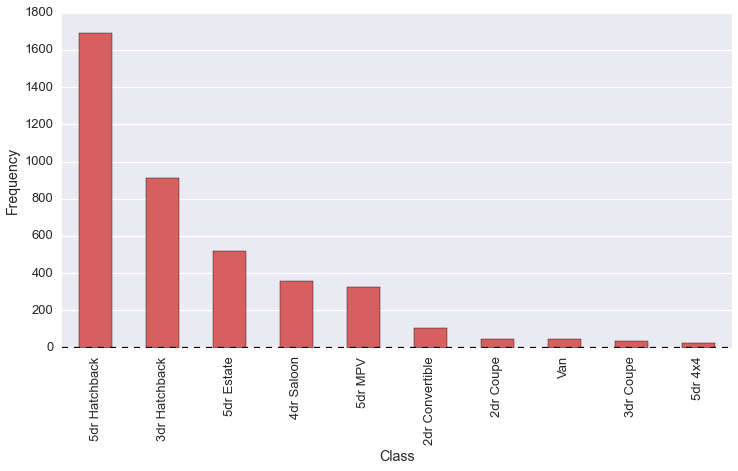

In [19]:
plt.figure(figsize=(12, 6))
class_counts = df_enc['class'].value_counts()
class_counts.index = decoder['class'][class_counts.index]
class_counts[:10].plot(kind='bar', color=muted[2])
plt.grid(axis='x')
sns.axlabel('Class', 'Frequency')
print(df_enc.shape[0], ' Observations in Total')
print(' {0:.2%} are Hatchbacks'.format((class_counts[0] + class_counts[1]) / float(df_enc.shape[0])))

## Price vs Year

Clear positive correlation between data of manufacture and price the car was auctioned for. Therfore the newer the car, the more its sold for.  

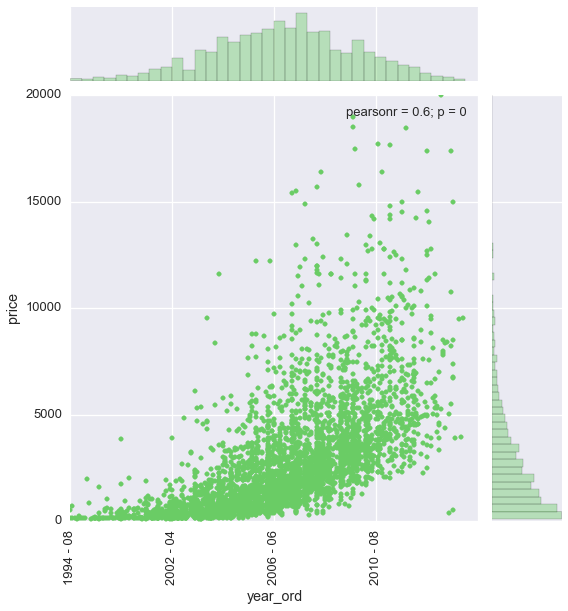

In [20]:
ax = sns.jointplot("year_ord", "price", df_enc, kind="scatter", size=8,
              ylim=(0, 20000), xlim=(0, 200), 
              color=muted[1])
years = pd.to_datetime(decoder['year'])
xlables = [years[i].strftime('%Y - %m') for i in range(0,151,50)]
ax.ax_joint.set_xticklabels(xlables, rotation='vertical');

## Price vs Mileage

A partial negative corelation between price and milage. As may be expected, cars that have done more miles tend to be sold at a lower price. 

No Mileage recorded in 0 observations


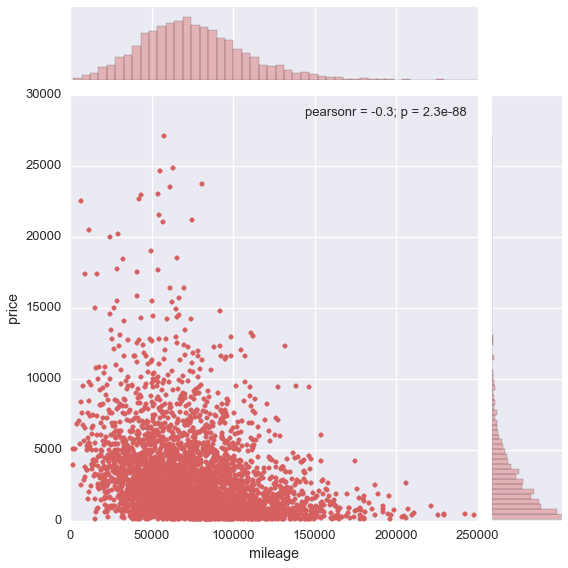

In [21]:
# Remove encoded NAs 
nas = sum(df_enc['mileage'] > 999999999)
print('No Mileage recorded in %d observations' % nas)
data = df_enc.loc[df_enc['mileage'] < 999999999, :]

ax = sns.jointplot("mileage", "price", data, kind="scatter", size=8, 
                   xlim = [0, 250000], ylim = [0, 30000], color=muted[2])

## Price Distribution vs Model

The pice distribution broken down by the top 16 car models is shown below. All follow a similarly skewed distribution, with a large proportion of low valued cars.  

In [22]:
# find index to the top 16 models
model_counts = df_enc['model'].value_counts()
top_16 = model_counts[:16].index
top_16_idx = df_enc.model.isin(top_16)
# Extract the top 16 as a subset and decode ID to find thier model name
if df_enc.ix[top_16_idx,'model'].dtype == int:
    model_names = df_enc.ix[top_16_idx, 'model'].copy().apply(lambda x: decoder['model'][x])
df_enc.ix[top_16_idx,'model'] = model_names

In [23]:
# Custom function to format facet grid plot 
def set_xticklabels(g, labels=None, step=None, **kwargs):
    """Set x axis tick labels on the bottom row of the grid."""
    for ax in g.axes[-4:]:
        if labels is None:
            labels = [l.get_text() for l in ax.get_xticklabels()]
            if step is not None:
                xticks = ax.get_xticks()[::step]
                labels = labels[::step]
                ax.set_xticks(xticks)
        ax.set_xticklabels(labels, **kwargs)
    return g

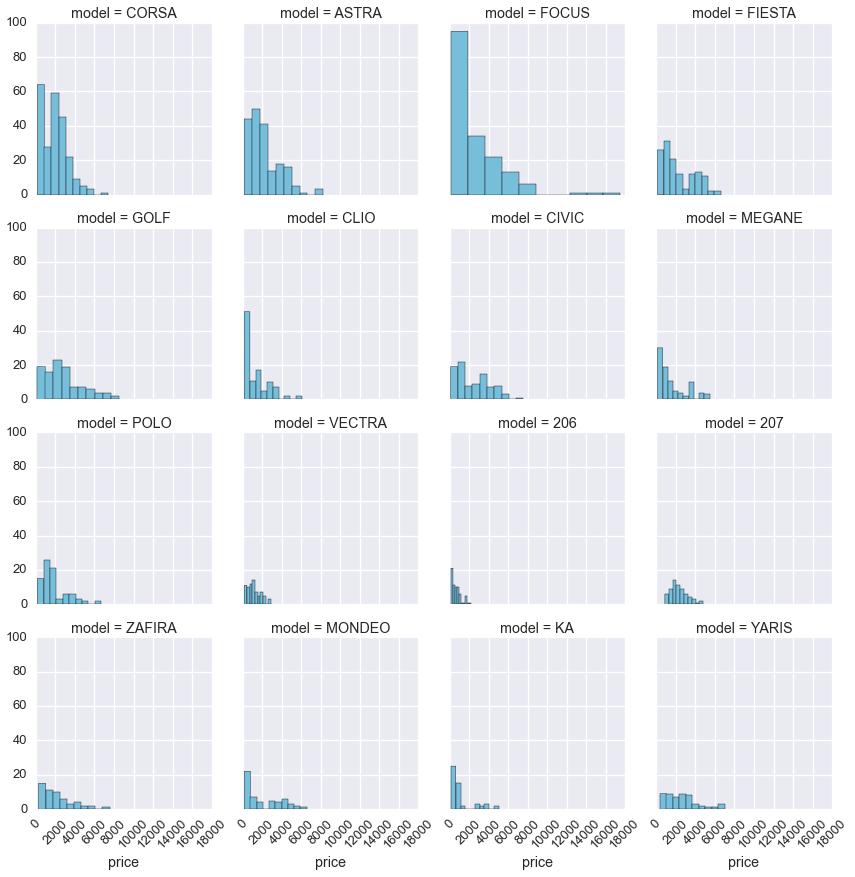

In [24]:
# Initialise Grid and populate with a histogram
g = sns.FacetGrid(df_enc.ix[top_16_idx, :], 
                  col="model", col_wrap=4, 
                  col_order=[decoder['model'][x] for x in top_16]) 
g.map(plt.hist, 'price', color=muted[5])
g = set_xticklabels(g, rotation = 45)

## Price vs Mileage vs Model

Similar overall neagative correlations are observed with higher auction prices reached for lower milage cars. 

In [25]:
# Define a subset that ignores the encoded NAs
na_idx = df_enc['mileage'] > 999999999
print('Total number of mailage NA values: {}'.format(na_idx.sum()))

Total number of mailage NA values: 0


In [26]:
# Define subset as those in top 16 and without na values
subset = df_enc.ix[top_16_idx & ~na_idx, :]

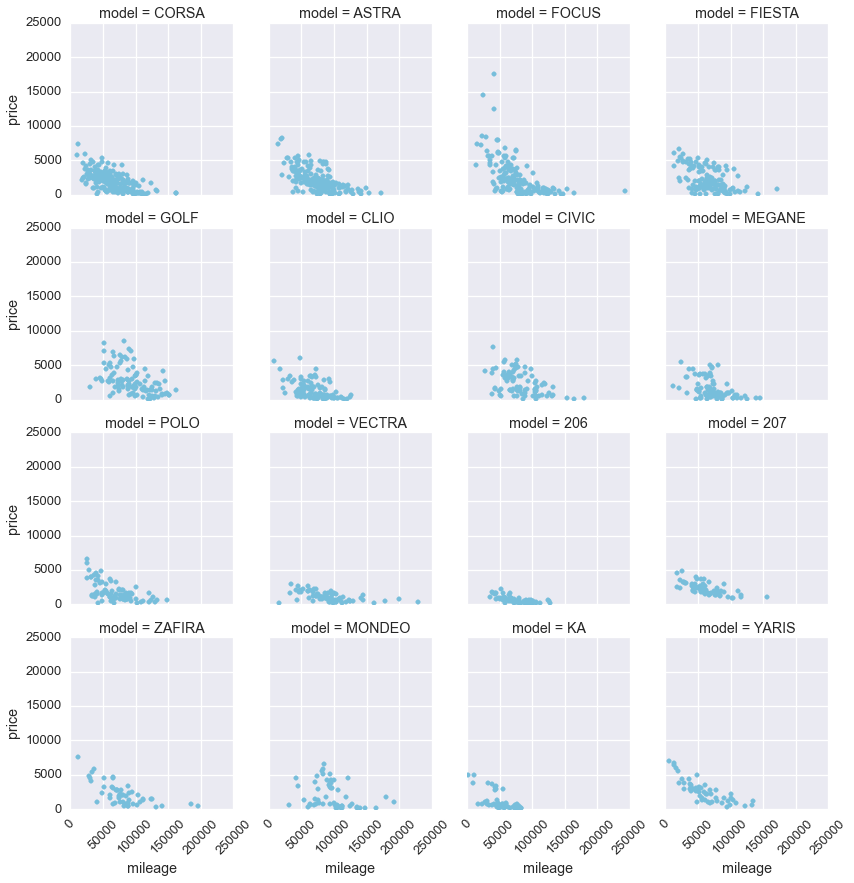

In [28]:
g = sns.FacetGrid(subset, col="model", 
                  col_wrap=4, 
                  col_order=[decoder['model'][x] for x in top_16], 
                  xlim =(0, 250000), ylim=(0, 25000)) 
g.map(plt.scatter, 'mileage', 'price', color=muted[5] )
g = set_xticklabels(g, rotation = 45)